## Importações

In [188]:
import pandas as pd
from math import floor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import norm
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix,recall_score,precision_score

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import f_classif, f_oneway, chi2,mutual_info_classif 
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import json


## Funções Comuns

In [189]:
def funcPlotMatriz(y_test, classificar):
    matriz_de_confusao = confusion_matrix(y_test, classificar)
    sns.heatmap(matriz_de_confusao, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
    plt.show()


def funcMetricas(df_metricas,modelo_Versao, df,quant_columns,Hyper_Parametros,y_test, classificar):
    metricas = [
        modelo_Versao,
        df,
        quant_columns,
        Hyper_Parametros,
        accuracy_score(y_test, classificar), 
        round(recall_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(precision_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(f1_score(y_test, classificar, pos_label=0,average='macro'),2)
        ]
    
    nova_linha_df = pd.DataFrame([metricas], columns=df_metricas.columns)

    df_metricas = pd.concat([df_metricas, nova_linha_df], ignore_index=True)
    
    return df_metricas


## Extraindo a Base

In [190]:
df_original = pd.read_excel('DataFrames\df_original.xlsx')

df = df_original.copy()

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III


### Dividindo o Dataframe em Valor Explicativo e Resposta

In [191]:
df_x ,df_y= df[['Height','Weight']],df.iloc[:, -1]

df_y = pd.DataFrame(df_y)
display(df_x)
display(df_y)

,Height,Weight
0,1.620000,64.000000
1,1.520000,56.000000
2,1.800000,77.000000
3,1.800000,87.000000
4,1.780000,89.800000
...,...,...
2106,1.710730,131.408528
2107,1.748584,133.742943
2108,1.752206,133.689352
2109,1.739450,133.346641


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II
...,...
2106,Obesity_Type_III
2107,Obesity_Type_III
2108,Obesity_Type_III
2109,Obesity_Type_III


#### Dividindo os DataFrames de Teste e Treino

In [192]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25,random_state=42,shuffle=True)
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)


### PIPELINE

In [193]:
df_knn = pd.read_excel('DataFrames/df_knn.xlsx')
df_knn =df_knn.drop('Unnamed: 0', axis=1)
df_knn = df_knn.head(1)

display(df_knn)

,Modelo,DF,Quant_columns,Hyper_Parametros,Acuracia,Recall_Media,Precision_Media,F1_Score_Media
0,KNN,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.952652,0.95,0.95,0.95


In [194]:
params_pipe = df_knn['Hyper_Parametros'][0]

Como não é possível extrair os hiperparâmetros por código, extraí manualmente e modifiquei algumas coisas.

In [195]:
params_pipe = {'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 2, 'model__weights': 'distance', 'pca__n_components': 2}


                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.97      0.95        68
      Normal_Weight       0.93      0.88      0.91        78
     Obesity_Type_I       0.98      0.96      0.97        94
    Obesity_Type_II       0.95      0.96      0.95        75
   Obesity_Type_III       0.99      0.99      0.99        79
 Overweight_Level_I       0.93      0.93      0.93        71
Overweight_Level_II       0.95      0.98      0.97        63

           accuracy                           0.95       528
          macro avg       0.95      0.95      0.95       528
       weighted avg       0.95      0.95      0.95       528



c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


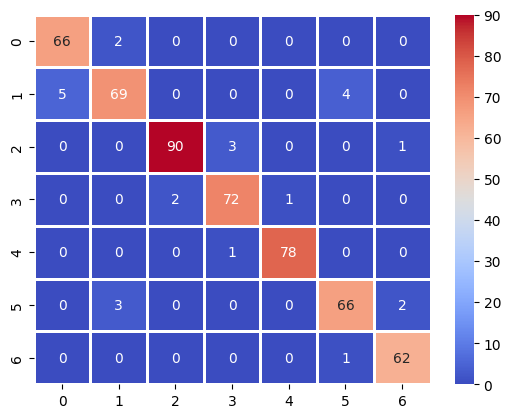

In [196]:
pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('model', KNeighborsClassifier())
            ])

pipe.set_params(**params_pipe)
pipe.fit(X_train,y_train)

previsao = pipe.predict(X_test)
metricas = classification_report(y_test,previsao)
print(metricas)
funcPlotMatriz(y_test, previsao)
    

### Serialização

In [197]:
import pickle

In [198]:

filename = 'modelo.pkl'
pickle.dump(pipe, open(filename, 'wb'))
